In [24]:
import pandas as pd
import numpy as np
import duckdb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

modelling_conn = duckdb.connect('modelling_db')

In [27]:
def treinar_modelos_precipitacao(
    abt_estacoes_vizinhas,
    threshold_prioridade,
    percent_datetime_partitioning_split,
    featurelist_com_vizinha,
    featurelist_sem_vizinha
):
    # Separar com e sem vizinha
    abt_com_vizinha = abt_estacoes_vizinhas.loc[
        abt_estacoes_vizinhas['vl_prioridade_vizinha'] >= threshold_prioridade
    ].sort_values(by=['id_estacao','dt_medicao'])

    abt_sem_vizinha = abt_estacoes_vizinhas.loc[
        abt_estacoes_vizinhas['vl_prioridade_vizinha'].fillna(0) < threshold_prioridade
    ].sort_values(by=['id_estacao','dt_medicao'])

    # Split por estação
    treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
        lambda g: g.iloc[:max(1, int(len(g) * percent_datetime_partitioning_split))]
    ).reset_index(drop=True)

    validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
        lambda g: g.iloc[max(1, int(len(g) * percent_datetime_partitioning_split)):]
    ).reset_index(drop=True)

    treinamento_sem_vizinha = abt_sem_vizinha.groupby('id_estacao', as_index=False).apply(
        lambda g: g.iloc[:max(1, int(len(g) * percent_datetime_partitioning_split))]
    ).reset_index(drop=True)

    validacao_sem_vizinha = abt_sem_vizinha.groupby('id_estacao', as_index=False).apply(
        lambda g: g.iloc[max(1, int(len(g) * percent_datetime_partitioning_split)):]
    ).reset_index(drop=True)

    # Features e target
    X_com_vizinha_treino = treinamento_com_vizinha[featurelist_com_vizinha]
    y_com_vizinha_treino = treinamento_com_vizinha['vl_precipitacao']
    X_sem_vizinha_treino = treinamento_sem_vizinha[featurelist_sem_vizinha]
    y_sem_vizinha_treino = treinamento_sem_vizinha['vl_precipitacao']

    params = {
        "tree_method": "gpu_hist",     # ativa GPU
        "predictor": "gpu_predictor"  # também força a predição na GPU
    }

    # Treinar modelos
    xgboost_com_vizinha = XGBRegressor(**params)
    xgboost_sem_vizinha = XGBRegressor(**params)

    xgboost_com_vizinha.fit(X_com_vizinha_treino, y_com_vizinha_treino)
    xgboost_sem_vizinha.fit(X_sem_vizinha_treino, y_sem_vizinha_treino)

    # Validação
    X_com_vizinha_valid = validacao_com_vizinha[featurelist_com_vizinha]
    y_com_vizinha_valid = validacao_com_vizinha['vl_precipitacao']
    X_sem_vizinha_valid = validacao_sem_vizinha[featurelist_sem_vizinha]
    y_sem_vizinha_valid = validacao_sem_vizinha['vl_precipitacao']

    y_com_vizinha_pred = xgboost_com_vizinha.predict(X_com_vizinha_valid)
    y_sem_vizinha_pred = xgboost_sem_vizinha.predict(X_sem_vizinha_valid)

    # Métricas
    metrics = {
        "com_vizinha": {
            "model": xgboost_com_vizinha,
            "mse": mean_squared_error(y_com_vizinha_valid, y_com_vizinha_pred),
            "rmse": np.sqrt(mean_squared_error(y_com_vizinha_valid, y_com_vizinha_pred)),
            "mae": mean_absolute_error(y_com_vizinha_valid, y_com_vizinha_pred),
            "r2": r2_score(y_com_vizinha_valid, y_com_vizinha_pred)
        },
        "sem_vizinha": {
            "model": xgboost_sem_vizinha,
            "mse": mean_squared_error(y_sem_vizinha_valid, y_sem_vizinha_pred),
            "rmse": np.sqrt(mean_squared_error(y_sem_vizinha_valid, y_sem_vizinha_pred)),
            "mae": mean_absolute_error(y_sem_vizinha_valid, y_sem_vizinha_pred),
            "r2": r2_score(y_sem_vizinha_valid, y_sem_vizinha_pred)
        }
    }

    return metrics

In [21]:
threshold_prioridade = 0.5
percent_datetime_partitioning_split = 0.7

featurelist_com_vizinha = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano',
                           'vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo',
                           'vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media', 
                           'vl_precipitacao_chirps','vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc', 'vl_precipitacao_gpm_final_run','vl_precipitacao_gpm_late_run', 
                           'vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power', 
                           'vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power', 
                           'vl_precipitacao_vizinha','vl_prioridade_vizinha']

featurelist_sem_vizinha = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano',
                           'vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo',
                           'vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media', 
                           'vl_precipitacao_chirps','vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc', 'vl_precipitacao_gpm_final_run','vl_precipitacao_gpm_late_run', 
                           'vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power', 
                           'vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']

abt_estacoes_vizinhas = modelling_conn.execute("""
SELECT * FROM abt_estacoes_vizinhas
""").fetchdf()

abt_estacoes_vizinhas['dt_medicao_mes'] = abt_estacoes_vizinhas['dt_medicao'].dt.month
abt_estacoes_vizinhas['dt_medicao_ano'] = abt_estacoes_vizinhas['dt_medicao'].dt.year

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [28]:
resultados_lista = []

for threshold in np.arange(0.1, 1.0, 0.1):
    print(f"\n=== Treinando modelos com threshold_prioridade = {threshold:.1f} ===")
    resultados = treinar_modelos_precipitacao(
        abt_estacoes_vizinhas=abt_estacoes_vizinhas,
        threshold_prioridade=threshold,
        percent_datetime_partitioning_split=percent_datetime_partitioning_split,
        featurelist_com_vizinha=featurelist_com_vizinha,
        featurelist_sem_vizinha=featurelist_sem_vizinha
    )
    
    resultados_lista.append({
        'threshold_prioridade': threshold,
        'rmse_com_vizinha': resultados['com_vizinha']['rmse'],
        'mae_com_vizinha': resultados['com_vizinha']['mae'],
        'r2_com_vizinha': resultados['com_vizinha']['r2'],
        'rmse_sem_vizinha': resultados['sem_vizinha']['rmse'],
        'mae_sem_vizinha': resultados['sem_vizinha']['mae'],
        'r2_sem_vizinha': resultados['sem_vizinha']['r2']
    })



=== Treinando modelos com threshold_prioridade = 0.1 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.2 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.3 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.4 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.5 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.6 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.7 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.8 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.9 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in

In [41]:
import seaborn as sns
df = pd.DataFrame(resultados_lista)

In [44]:
resultados_lista

[{'threshold_prioridade': 0.1,
  'rmse_com_vizinha': 7.295395771779301,
  'mae_com_vizinha': 2.8775214775904545,
  'r2_com_vizinha': 0.49850001977557534,
  'rmse_sem_vizinha': 9.204951775602005,
  'mae_sem_vizinha': 3.912417802824901,
  'r2_sem_vizinha': 0.2411286733838921},
 {'threshold_prioridade': 0.2,
  'rmse_com_vizinha': 7.248513153573471,
  'mae_com_vizinha': 2.8621361918262784,
  'r2_com_vizinha': 0.5055220827475173,
  'rmse_sem_vizinha': 9.244575017509634,
  'mae_sem_vizinha': 3.9205472511606416,
  'r2_sem_vizinha': 0.21563998923614758},
 {'threshold_prioridade': 0.30000000000000004,
  'rmse_com_vizinha': 7.137294929988519,
  'mae_com_vizinha': 2.8083839046485126,
  'r2_com_vizinha': 0.518215995116264,
  'rmse_sem_vizinha': 9.048760862307686,
  'mae_sem_vizinha': 3.821782090162594,
  'r2_sem_vizinha': 0.2640573713673384},
 {'threshold_prioridade': 0.4,
  'rmse_com_vizinha': 6.93851381192541,
  'mae_com_vizinha': 2.696782634250955,
  'r2_com_vizinha': 0.5444303171026992,
  'rms

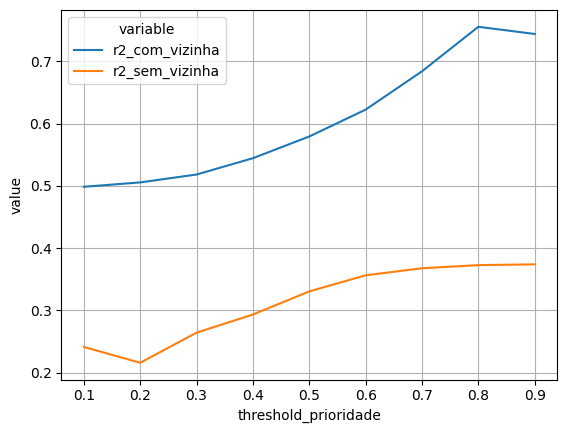

In [43]:
sns.lineplot(data=pd.melt(df[['threshold_prioridade','r2_com_vizinha','r2_sem_vizinha']],id_vars=['threshold_prioridade']),x='threshold_prioridade',y='value',hue='variable')
plt.grid()

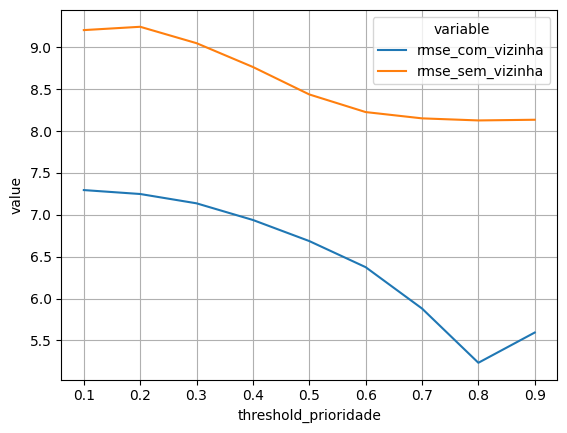

In [45]:
sns.lineplot(data=pd.melt(df[['threshold_prioridade','rmse_com_vizinha','rmse_sem_vizinha']],id_vars=['threshold_prioridade']),x='threshold_prioridade',y='value',hue='variable')
plt.grid()

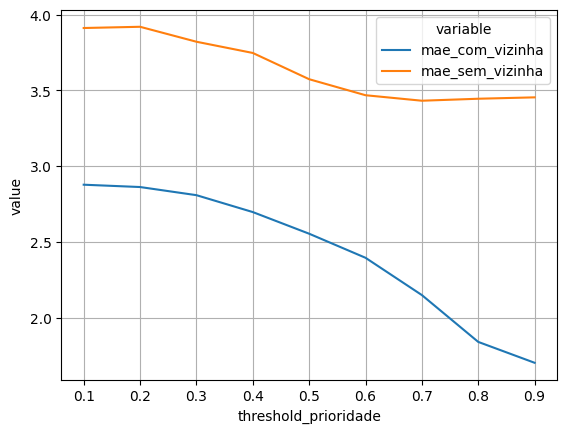

In [49]:
sns.lineplot(data=pd.melt(df[['threshold_prioridade','mae_com_vizinha','mae_sem_vizinha']],id_vars=['threshold_prioridade']),x='threshold_prioridade',y='value',hue='variable')
plt.grid()

In [47]:
len(abt_estacoes_vizinhas.loc[abt_estacoes_vizinhas['vl_prioridade_vizinha']>=0.8])

2581500

In [48]:
len(abt_estacoes_vizinhas.loc[abt_estacoes_vizinhas['vl_prioridade_vizinha']<0.8])

15579506

In [ ]:
# threshold = 0.5
# Modelo com vizinha:
#   MSE : 44.7095
#   RMSE: 6.6865
#   MAE : 2.5537
#   R²  : 0.5794

# Modelo sem vizinha:
#   MSE : 71.1782
#   RMSE: 8.4367
#   MAE : 3.5742
#   R²  : 0.3304
